# Soccer Match Outcome Predictor

The following code will build a soccer match outcome prediction model using nural networks with team embeddings and match history embeddings.

Installing Necessary Packages

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Input, Dense, Concatenate, Dropout, Flatten, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
from keras import layers, models, optimizers, callbacks
import keras_tuner as kt

## Preprocessing the Dataset

Loading the Dataset

In [3]:
df = pd.read_csv('matches_expanded.csv')
df.head(10)

,match_id,home_team,away_team,home_goals,away_goals,match_outcome,Home_Ball_Possession,Home_Pass_Accuracy,Home_Total_Shots,Home_Expected_Goals,Away_Ball_Possession,Away_Pass_Accuracy,Away_Total_Shots,Away_Expected_Goals
0,1035037,Burnley,Manchester City,0,3,Loss,34%,79%,6,0.33,66%,90%,17,2.08
1,1035038,Arsenal,Nottingham Forest,2,1,Win,78%,90%,15,0.83,22%,69%,6,1.18
2,1035039,Bournemouth,West Ham,1,1,Draw,63%,82%,14,1.37,37%,68%,16,1.07
3,1035041,Everton,Fulham,0,1,Loss,41%,79%,19,2.73,59%,85%,9,1.50
4,1035040,Brighton,Luton,4,1,Win,71%,91%,27,4.01,29%,72%,9,1.48
5,1035042,Sheffield Utd,Crystal Palace,0,1,Loss,32%,62%,8,0.51,68%,83%,24,1.89
6,1035043,Newcastle,Aston Villa,5,1,Win,53%,85%,17,3.41,47%,85%,16,1.77
7,1035044,Brentford,Tottenham,2,2,Draw,30%,77%,11,2.22,70%,90%,18,1.27
8,1035045,Chelsea,Liverpool,1,1,Draw,65%,87%,10,1.35,35%,80%,13,1.28
9,1035046,Manchester United,Wolves,1,0,Win,51%,82%,15,2.21,49%,81%,23,2.35


Cleaning the Dataset

In [4]:
df.columns = df.columns.str.lower()

df['home_ball_possession'] = df['home_ball_possession'].str.replace('%', '', regex=True).astype(float)
df['home_pass_accuracy'] = df['home_pass_accuracy'].str.replace('%', '', regex=True).astype(float)
df['away_ball_possession'] = df['away_ball_possession'].str.replace('%', '', regex=True).astype(float)
df['away_pass_accuracy'] = df['away_pass_accuracy'].str.replace('%', '', regex=True).astype(float)

# Feature Engineering

Adding New Statistics

In [5]:
df["home_goals_conceeded"] = df["away_goals"]
df["away_goals_conceeded"] = df["home_goals"]

df["home_expected_goals_against"] = df["away_expected_goals"]
df["away_expected_goals_against"] = df["home_expected_goals"]

df["home_conversion_rate"] = df["home_goals"] / df["home_total_shots"]
df["away_conversion_rate"] = df["away_goals"] / df["away_total_shots"]

df["home_goal_difference"] = df["home_goals"] - df["away_goals"]
df["away_goal_difference"] = df["away_goals"] - df["home_goals"]

df["home_goals_conceeded_difference"] = df["home_goals_conceeded"] - df["away_goals_conceeded"]
df["away_goals_conceeded_difference"] = df["away_goals_conceeded"] - df["home_goals_conceeded"]

df["home_ball_possession_difference"]= df["home_ball_possession"] - df["away_ball_possession"]
df["away_ball_possession_difference"] = df["away_ball_possession"] - df["home_ball_possession"]

df["home_pass_accuracy_difference"] = df["home_pass_accuracy"] - df["away_pass_accuracy"]
df["away_pass_accuracy_difference"] = df["away_pass_accuracy"] - df["home_pass_accuracy"]

df["home_expected_goals_difference"] = df["home_expected_goals"] - df["away_expected_goals"]
df["away_expected_goals_difference"] = df["away_expected_goals"] - df["home_expected_goals"]

df["home_expected_goals_against_difference"] = df["home_expected_goals_against"] - df["away_expected_goals_against"]
df["away_expected_goals_against_difference"] = df["away_expected_goals_against"] - df["home_expected_goals_against"]

df["home_shot_difference"] = df["home_total_shots"] - df["away_total_shots"]
df["away_shot_difference"] = df["away_total_shots"] - df["home_total_shots"]

df["home_conversion_rate_difference"] = df["home_conversion_rate"] - df["away_conversion_rate"]
df["away_conversion_rate_difference"] = df["away_conversion_rate"] - df["home_conversion_rate"]


Capturing the Statistics of a Team Over 5 Matches

In [6]:
# Function to compute rolling averages for all rows in the DataFrame
def add_rolling_avg_stat(df, stat_col_prefix, num_matches=5):
    home_avgs = []
    away_avgs = []

    for i in range(len(df)):
        current_row = df.iloc[i]
        home_team = current_row["home_team"]
        away_team = current_row["away_team"]
        prior_matches = df.iloc[:i]

        # Get home team history
        home_matches = prior_matches[
            (prior_matches["home_team"] == home_team) | (prior_matches["away_team"] == home_team)
        ].tail(num_matches)

        home_values = []
        for _, m in home_matches.iterrows():
            if m["home_team"] == home_team:
                home_values.append(m[f"home_{stat_col_prefix}"])
            else:
                home_values.append(m[f"away_{stat_col_prefix}"])
        home_avg = np.mean(home_values) if home_values else np.nan
        if np.isnan(home_avg):
            home_avg = current_row[f"home_{stat_col_prefix}"]
        home_avgs.append(home_avg)

        # Get away team history
        away_matches = prior_matches[
            (prior_matches["home_team"] == away_team) | (prior_matches["away_team"] == away_team)
        ].tail(num_matches)

        away_values = []
        for _, m in away_matches.iterrows():
            if m["home_team"] == away_team:
                away_values.append(m[f"home_{stat_col_prefix}"])
            else:
                away_values.append(m[f"away_{stat_col_prefix}"])
        away_avg = np.mean(away_values) if away_values else np.nan
        if np.isnan(away_avg):
            away_avg = current_row[f"away_{stat_col_prefix}"]
        away_avgs.append(away_avg)

    # Store in DataFrame
    df[f"home_{stat_col_prefix}_last{num_matches}_avg"] = home_avgs
    df[f"away_{stat_col_prefix}_last{num_matches}_avg"] = away_avgs

    return df

# Apply function to statistics
stats_to_process = ["goals", "ball_possession", "pass_accuracy", "total_shots", "expected_goals", "expected_goals_against", "conversion_rate", "goal_difference", "expected_goals_difference", "expected_goals_against_difference", "shot_difference","ball_possession_difference", "pass_accuracy_difference", "conversion_rate_difference", "goals_conceeded", "goals_conceeded_difference"]

for stat in stats_to_process:
    df = add_rolling_avg_stat(df, stat, num_matches=5)


In [7]:
df['home_under_1_5_goals_last5'] = df['home_goals_last5_avg'] < 1.5
df['away_under_1_5_goals_last5'] = df['away_goals_last5_avg'] < 1.5

Capturing the Statistics of a Team Over The Season

In [ ]:
def add_avg_stat_all_history(df, stat_col_prefix):
    home_avgs = []
    away_avgs = []

    for i in range(len(df)):
        current_row = df.iloc[i]
        home_team = current_row["home_team"]
        away_team = current_row["away_team"]
        prior_matches = df.iloc[:i]

        # Home team average (all matches before i)
        home_values = []
        for _, match in prior_matches.iterrows():
            if match["home_team"] == home_team:
                home_values.append(match[f"home_{stat_col_prefix}"])
            elif match["away_team"] == home_team:
                home_values.append(match[f"away_{stat_col_prefix}"])
        home_avg = np.mean(home_values) if home_values else np.nan
        if np.isnan(home_avg):
            home_avg = current_row[f"home_{stat_col_prefix}"]
        home_avgs.append(home_avg)

        # Away team average (all matches before i)
        away_values = []
        for _, match in prior_matches.iterrows():
            if match["home_team"] == away_team:
                away_values.append(match[f"home_{stat_col_prefix}"])
            elif match["away_team"] == away_team:
                away_values.append(match[f"away_{stat_col_prefix}"])
        away_avg = np.mean(away_values) if away_values else np.nan
        if np.isnan(away_avg):
            away_avg = current_row[f"away_{stat_col_prefix}"]
        away_avgs.append(away_avg)

    df[f"home_{stat_col_prefix}_avg_all"] = home_avgs
    df[f"away_{stat_col_prefix}_avg_all"] = away_avgs

    return df

stats_to_process = ["goals", "ball_possession", "pass_accuracy", "total_shots", "expected_goals", "expected_goals_against", "conversion_rate", "goal_difference", "expected_goals_difference", "expected_goals_against_difference", "shot_difference","ball_possession_difference", "pass_accuracy_difference", "conversion_rate_difference", "goals_conceeded", "goals_conceeded_difference"]

for stat in stats_to_process:
    df = add_avg_stat_all_history(df, stat)

Capturing League Form (how many wins, draws, losses in 5 games)

In [8]:
def add_last5_results(df, num_matches=5):
    home_wins, home_draws, home_losses = [], [], []
    away_wins, away_draws, away_losses = [], [], []

    for i in range(len(df)):
        current_row = df.iloc[i]
        home_team = current_row["home_team"]
        away_team = current_row["away_team"]
        prior_matches = df.iloc[:i]

        def get_team_result(row, team):
            if row["home_team"] == team:
                if row["home_goals"] > row["away_goals"]:
                    return "win"
                elif row["home_goals"] < row["away_goals"]:
                    return "loss"
                else:
                    return "draw"
            elif row["away_team"] == team:
                if row["away_goals"] > row["home_goals"]:
                    return "win"
                elif row["away_goals"] < row["home_goals"]:
                    return "loss"
                else:
                    return "draw"
            else:
                return None

        home_matches = prior_matches[
            (prior_matches["home_team"] == home_team) | (prior_matches["away_team"] == home_team)
        ].tail(num_matches)
        home_results = [get_team_result(m, home_team) for _, m in home_matches.iterrows()]
        home_wins.append(home_results.count("win"))
        home_draws.append(home_results.count("draw"))
        home_losses.append(home_results.count("loss"))

        away_matches = prior_matches[
            (prior_matches["home_team"] == away_team) | (prior_matches["away_team"] == away_team)
        ].tail(num_matches)
        away_results = [get_team_result(m, away_team) for _, m in away_matches.iterrows()]
        away_wins.append(away_results.count("win"))
        away_draws.append(away_results.count("draw"))
        away_losses.append(away_results.count("loss"))

    new_columns_last5 = pd.DataFrame({
    "home_wins_last5": home_wins,
    "home_draws_last5": home_draws,
    "home_losses_last5": home_losses,
    "away_wins_last5": away_wins,
    "away_draws_last5": away_draws,
    "away_losses_last5": away_losses
    })

    df = pd.concat([df, new_columns_last5], axis=1)

    return df

df = add_last5_results(df, num_matches=5)

Capturing Season Long Results (how many wins, draws, losses across the entire season)

In [ ]:
def add_result_history(df):
    home_wins, home_draws, home_losses = [], [], []
    away_wins, away_draws, away_losses = [], [], []

    for i in range(len(df)):
        row = df.iloc[i]
        home_team = row["home_team"]
        away_team = row["away_team"]
        prior = df.iloc[:i]

        def result(row, team):
            if row["home_team"] == team:
                return "win" if row["home_goals"] > row["away_goals"] else "loss" if row["home_goals"] < row["away_goals"] else "draw"
            if row["away_team"] == team:
                return "win" if row["away_goals"] > row["home_goals"] else "loss" if row["away_goals"] < row["home_goals"] else "draw"

        home_results = [result(m, home_team) for _, m in prior[(prior["home_team"] == home_team) | (prior["away_team"] == home_team)].iterrows()]
        away_results = [result(m, away_team) for _, m in prior[(prior["home_team"] == away_team) | (prior["away_team"] == away_team)].iterrows()]

        home_wins.append(home_results.count("win"))
        home_draws.append(home_results.count("draw"))
        home_losses.append(home_results.count("loss"))
        away_wins.append(away_results.count("win"))
        away_draws.append(away_results.count("draw"))
        away_losses.append(away_results.count("loss"))

    new_columns_all = pd.DataFrame({
    "home_wins_all": home_wins,
    "home_draws_all": home_draws,
    "home_losses_all": home_losses,
    "away_wins_all": away_wins,
    "away_draws_all": away_draws,
    "away_losses_all": away_losses
    })

    df = pd.concat([df, new_columns_all], axis=1)

    return df

df = add_result_history(df)

In [9]:
df['win_diff_last5'] = df['home_wins_last5'] - df['away_wins_last5']
df['draw_diff_last5'] = df['home_draws_last5'] - df['away_draws_last5']
df['loss_diff_last5'] = df['home_losses_last5'] - df['away_losses_last5']


In [ ]:
df['win_diff_all'] = df['home_wins_all'] - df['away_wins_all']
df['draw_diff_all'] = df['home_draws_all'] - df['away_draws_all']
df['loss_diff_all'] = df['home_losses_all'] - df['away_losses_all']

In [10]:
df.to_csv('features.csv', index=False)

## Building the Neural Network Model

Label Ecode Team Names

In [11]:
team_encoder = LabelEncoder()
df['home_team_id'] = team_encoder.fit_transform(df['home_team'])
df['away_team_id'] = team_encoder.transform(df['away_team'])

Implementing Standard Scaling

In [12]:
numerical_cols = [col for col in df.columns if col.endswith('_last5_avg') or col.endswith('_avg_all') or col.endswith('_last5') or col.endswith('_all')]
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

Gathering Inputs

In [ ]:
X = df[numerical_cols]
X = X.copy()
X['home_team_id'] = df['home_team_id'].values
X['away_team_id'] = df['away_team_id'].values


Label Encode Target (Win/Draw/Loss)

In [14]:
outcome_encoder = LabelEncoder()
df['outcome_encoded'] = outcome_encoder.fit_transform(df['match_outcome'])
y = to_categorical(df['outcome_encoded'], num_classes=3)



Spliting Data Into Training and Test Datasets

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(80/380), shuffle=False)

Calculating Class Weights

In [16]:
classes= np.array([0, 1, 2])
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1, 2]), y=np.argmax(y_train, axis=1))
class_weight_dict = {0: class_weights[0], 1: class_weights[1], 2: class_weights[2]}
print(class_weight_dict) 


{0: 1.4705882352941178, 1: 1.0638297872340425, 2: 0.7246376811594203}


Helpful Features for Training

In [17]:
# Early stopping callback to stop training when the validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Learning rate scheduler to reduce the learning rate when the validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

Building the Model

In [18]:
input_layer = Input(shape=(X_train.shape[1],))
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_layer)
x = Dropout(0.5)(x)  
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)  
x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
output_layer = Dense(3, activation='softmax')(x)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Training the Model

In [ ]:
# Training the model with class weights to address imbalance, early stopping, and learning rate scheduler
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr], class_weight=class_weight_dict, verbose=1)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.2984 - loss: 4.0141 - val_accuracy: 0.4250 - val_loss: 2.9021 - learning_rate: 0.0010
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3555 - loss: 3.2279 - val_accuracy: 0.4875 - val_loss: 2.8275 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3533 - loss: 3.1571 - val_accuracy: 0.4250 - val_loss: 2.7815 - learning_rate: 0.0010
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3943 - loss: 2.9306 - val_accuracy: 0.4125 - val_loss: 2.7227 - learning_rate: 0.0010
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3976 - loss: 2.8564 - val_accuracy: 0.4125 - val_loss: 2.6679 - learning_rate: 0.0010
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4124 - loss: 2.7720 - val_accuracy: 0.4750 - val_loss: 2.6029 - learning_rate: 0.0010
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4173 - loss: 2.6468 -

## Evaluating the Model

Predict and Evaluate

In [ ]:
# Predict probabilities on the test set
y_test_probs = model.predict(X_test)

# Predicted class labels (Win, Draw, Loss)
y_test_pred = np.argmax(y_test_probs, axis=1)

# True class labels 
y_test_true = np.argmax(y_test, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


In [21]:
print("Accuracy:", accuracy_score(y_test_true, y_test_pred))
print("Classification Report:\n", classification_report(y_test_true, y_test_pred, target_names=outcome_encoder.classes_))


Accuracy: 0.6125
Classification Report:
               precision    recall  f1-score   support

        Draw       0.29      0.36      0.32        14
        Loss       0.67      0.69      0.68        29
         Win       0.73      0.65      0.69        37

    accuracy                           0.61        80
   macro avg       0.56      0.57      0.56        80
weighted avg       0.63      0.61      0.62        80



In [ ]:
y_test_pred_labels = outcome_encoder.inverse_transform(y_test_pred)
y_test_true_labels = outcome_encoder.inverse_transform(y_test_true)
test_results_df = pd.DataFrame({
    'Home Team': team_encoder.inverse_transform(X_test['home_team_id'].values),
    'Away Team': team_encoder.inverse_transform(X_test['away_team_id'].values),
    'Actual Outcome': y_test_true_labels,
    'Predicted Outcome': y_test_pred_labels,
    'Confidence': np.max(y_test_probs, axis=1),
    'Win Prob': y_test_probs[:, outcome_encoder.transform(['Win'])[0]],
    'Draw Prob': y_test_probs[:, outcome_encoder.transform(['Draw'])[0]],
    'Loss Prob': y_test_probs[:, outcome_encoder.transform(['Loss'])[0]]
})

test_results_df['Correct'] = (test_results_df['Actual Outcome'] == test_results_df['Predicted Outcome'])

print(test_results_df.head())
test_results_df.to_csv('test_results_1.csv', index=False)

         Home Team          Away Team Actual Outcome Predicted Outcome  \
0  Manchester City        Aston Villa            Win               Win   
1        Liverpool      Sheffield Utd            Win               Win   
2          Chelsea  Manchester United            Win               Win   
3   Crystal Palace    Manchester City           Loss              Loss   
4           Fulham          Newcastle           Loss               Win   

   Confidence  Win Prob  Draw Prob  Loss Prob  Correct  
0    0.586688  0.586688   0.205010   0.208302     True  
1    0.865663  0.865663   0.052476   0.081861     True  
2    0.551810  0.551810   0.239375   0.208815     True  
3    0.530454  0.147040   0.322506   0.530454     True  
4    0.527259  0.527259   0.242785   0.229956    False  


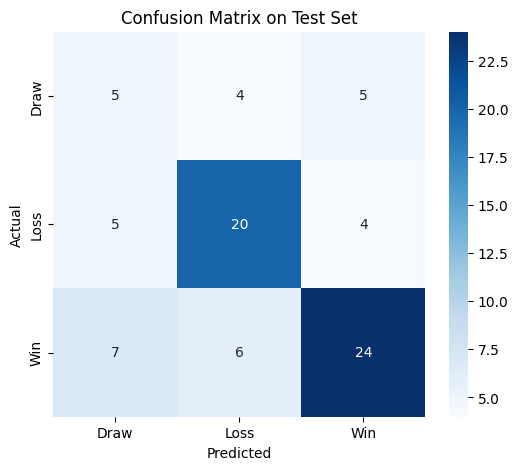

In [ ]:
cm = confusion_matrix(y_test_true_labels, y_test_pred_labels, labels=outcome_encoder.classes_)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=outcome_encoder.classes_,
            yticklabels=outcome_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

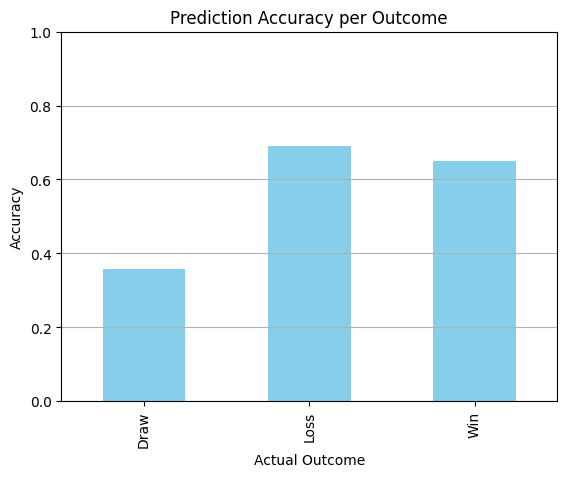

In [ ]:
outcome_accuracy = test_results_df.groupby('Actual Outcome')['Correct'].mean()

outcome_accuracy.plot(kind='bar', color='skyblue')
plt.ylabel('Accuracy')
plt.title('Prediction Accuracy per Outcome')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

Displaying Confidence in Predictions

In [ ]:
low_confidence_threshold = 0.6

test_results_df['Low-Confidence Wrong'] = (
    (~test_results_df['Correct']) & (test_results_df['Confidence'] < low_confidence_threshold)
)

low_conf_wrong_preds = test_results_df[test_results_df['Low-Confidence Wrong']]

print(f"Low-Confidence Wrong Predictions: {len(low_conf_wrong_preds)} matches")
print(low_conf_wrong_preds[['Home Team', 'Away Team', 'Actual Outcome', 'Predicted Outcome', 'Confidence']])

Low-Confidence Wrong Predictions: 23 matches
            Home Team          Away Team Actual Outcome Predicted Outcome  \
4              Fulham          Newcastle           Loss               Win   
6             Everton            Burnley            Win              Loss   
7         Aston Villa          Brentford           Draw               Win   
20           West Ham             Fulham           Loss              Draw   
21            Arsenal        Aston Villa           Loss               Win   
23      Sheffield Utd            Burnley           Loss              Draw   
26            Everton  Nottingham Forest            Win              Loss   
27     Crystal Palace           West Ham            Win              Draw   
28        Aston Villa        Bournemouth            Win              Draw   
34     Crystal Palace          Newcastle            Win              Draw   
37  Manchester United            Burnley           Draw               Win   
39             Fulham     Cryst

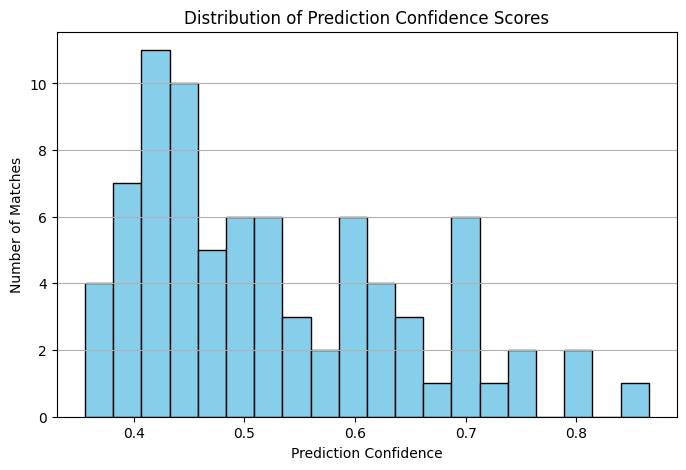

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(test_results_df['Confidence'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Prediction Confidence')
plt.ylabel('Number of Matches')
plt.title('Distribution of Prediction Confidence Scores')
plt.grid(axis='y')
plt.show()

Plotting Permutation Feature Importance

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


2025-05-13 13:41:03.175808: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-13 13:41:03.186326: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-13 13:41:03.255161: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-13 13:41:03.261152: I tensorflow/core/platform/cpu_featu

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/stepp
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/stepp
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3/3

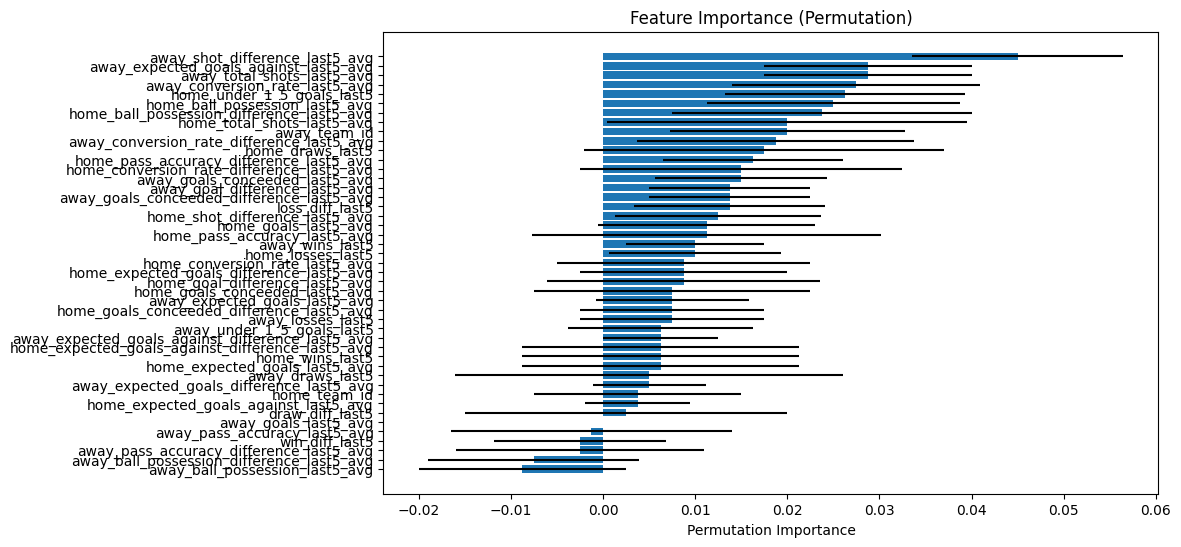

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

def keras_accuracy(y_true, y_pred):
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)  
    return accuracy_score(y_true_classes, y_pred_classes)

result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1, scoring=make_scorer(keras_accuracy))

importance = result.importances_mean  
std = result.importances_std  

for i, imp in enumerate(importance):
    print(f"Feature {i}: Importance = {imp}, Standard Deviation = {std[i]}")

sorted_idx = importance.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(X_test.shape[1]), importance[sorted_idx], xerr=std[sorted_idx], align="center")
plt.yticks(range(X_test.shape[1]), X_test.columns[sorted_idx])  # Assuming X_test has columns
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Permutation)")
plt.show()

## Hyperparameter Tuning

Defining a Hypermodel

In [ ]:
def build_model(hp):
    input_layer = layers.Input(shape=(X_train.shape[1],))
    
    x = layers.Dense(hp.Int('units_1', min_value=64, max_value=256, step=64), activation='relu')(input_layer)
    x = layers.Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = layers.Dense(hp.Int('units_2', min_value=64, max_value=256, step=64), activation='relu')(x)
    x = layers.Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1))(x)
    output_layer = layers.Dense(3, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG', default=1e-3)), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

Hyperparameter Search

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  
    executions_per_trial=3,  
    directory='kt_dir', 
    project_name='soccer_model_tuning'
)

# Run the hyperparameter search
tuner.search(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32)

# Get the best model
best_hp = tuner.get_best_models(num_models=1)[0]
best_hp.evaluate(X_test, y_test)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 10 Complete [00h 01m 14s]
val_accuracy: 0.5722222328186035

Best val_accuracy So Far: 0.6555555462837219
Total elapsed time: 00h 12m 55s


/Users/robertsandu/Documents/GitHub/MatchOutcomePredictor/.venv/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5273 - loss: 1.9804 


Validation Accuracy Across Trials

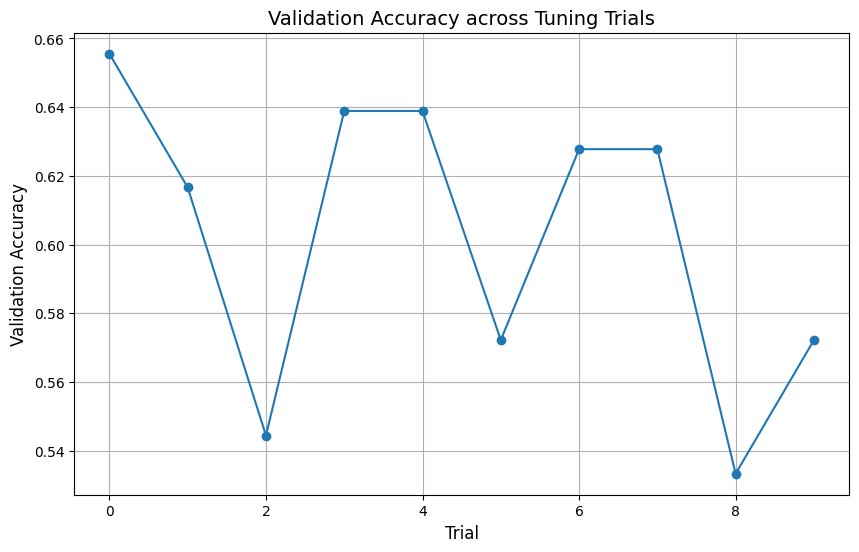

In [ ]:
trials = tuner.oracle.get_best_trials(num_trials=len(tuner.oracle.trials))

trial_scores = []
for trial in trials:
    trial_id = trial.trial_id
    metrics_names = trial.metrics.metrics.keys()  

    if 'val_accuracy' in metrics_names:
        val_score = trial.metrics.get_last_value('val_accuracy')
        metric_used = 'Validation Accuracy'
    elif 'val_loss' in metrics_names:
        val_score = -trial.metrics.get_last_value('val_loss')  
        metric_used = 'Negative Validation Loss'
    else:
        val_score = None  
        metric_used = 'Unknown'
    
    trial_scores.append((int(trial_id), val_score, metric_used))


trials_df = pd.DataFrame(trial_scores, columns=['Trial', 'Score', 'Metric'])


trials_df = trials_df.sort_values('Trial')


plt.figure(figsize=(10,6))
plt.plot(trials_df['Trial'], trials_df['Score'], marker='o')
plt.title('Validation Accuracy across Tuning Trials', fontsize=14)
plt.xlabel('Trial', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.grid(True)
plt.show()


## Training and Evaluating The Best Model Found

Predict and Evaluate

In [92]:
best_model = tuner.hypermodel.build(best_hps)
best_history = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, class_weight=class_weight_dict, verbose=1)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.3636 - loss: 1.7563 - val_accuracy: 0.3667 - val_loss: 1.1984
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4598 - loss: 1.1156 - val_accuracy: 0.5667 - val_loss: 0.9668
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4897 - loss: 1.0049 - val_accuracy: 0.5000 - val_loss: 1.0932
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6097 - loss: 0.9444 - val_accuracy: 0.3667 - val_loss: 1.1438
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5170 - loss: 0.9507 - val_accuracy: 0.3667 - val_loss: 1.0669
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6066 - loss: 0.8668 - val_accuracy: 0.5000 - val_loss: 0.9697
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6153 - loss: 0.8750 - val_accuracy: 0.3333 - val_loss: 1.2255
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6193 - loss: 0.7871 - val_accuracy: 0.5333 - val_loss: 1.0203


Predictions using the Best Model Found

In [93]:
y_best_test_probs = best_model.predict(X_test)

y_best_test_pred = np.argmax(y_best_test_probs, axis=1)

y_best_test_true = np.argmax(y_test, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Evaluating the Best Model

In [94]:
print("Accuracy:", accuracy_score(y_best_test_true, y_best_test_pred))
print("Classification Report:\n", classification_report(y_best_test_true, y_best_test_pred, target_names=outcome_encoder.classes_))

Accuracy: 0.575
Classification Report:
               precision    recall  f1-score   support

        Draw       0.50      0.36      0.42        14
        Loss       0.57      0.55      0.56        29
         Win       0.60      0.68      0.63        37

    accuracy                           0.57        80
   macro avg       0.56      0.53      0.54        80
weighted avg       0.57      0.57      0.57        80



In [95]:
y_best_test_pred_labels = outcome_encoder.inverse_transform(y_best_test_pred)
y_best_test_true_labels = outcome_encoder.inverse_transform(y_best_test_true)
best_test_results_df = pd.DataFrame({
    'Home Team': team_encoder.inverse_transform(X_test['home_team_id'].values),
    'Away Team': team_encoder.inverse_transform(X_test['away_team_id'].values),
    'Actual Outcome': y_best_test_true_labels,
    'Predicted Outcome': y_best_test_pred_labels,
    'Confidence': np.max(y_best_test_probs, axis=1),
    'Win Prob': y_best_test_probs[:, outcome_encoder.transform(['Win'])[0]],
    'Draw Prob': y_best_test_probs[:, outcome_encoder.transform(['Draw'])[0]],
    'Loss Prob': y_best_test_probs[:, outcome_encoder.transform(['Loss'])[0]]
})

best_test_results_df['Correct'] = (best_test_results_df['Actual Outcome'] == best_test_results_df['Predicted Outcome'])

print(best_test_results_df.head())
best_test_results_df.to_csv('hyper_test_results_1.csv', index=False)

         Home Team          Away Team Actual Outcome Predicted Outcome  \
0  Manchester City        Aston Villa            Win               Win   
1        Liverpool      Sheffield Utd            Win               Win   
2          Chelsea  Manchester United            Win               Win   
3   Crystal Palace    Manchester City           Loss              Loss   
4           Fulham          Newcastle           Loss               Win   

   Confidence  Win Prob     Draw Prob     Loss Prob  Correct  
0    0.809575  0.809575  8.981244e-04  1.895270e-01     True  
1    1.000000  1.000000  6.498813e-16  1.910511e-12     True  
2    0.555170  0.555170  4.422352e-01  2.594691e-03     True  
3    0.997368  0.002300  3.325696e-04  9.973675e-01     True  
4    0.726890  0.726890  6.375252e-03  2.667344e-01    False  


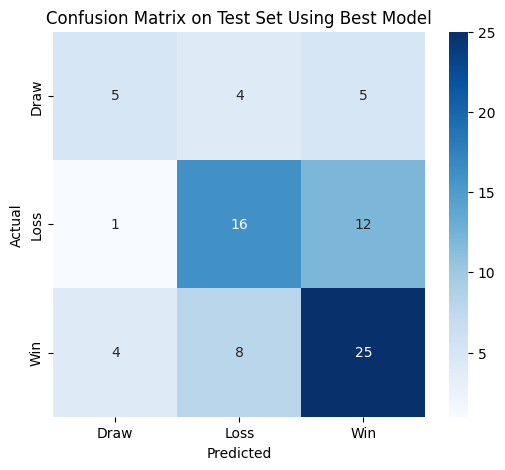

In [96]:
best_cm = confusion_matrix(y_best_test_true_labels, y_best_test_pred_labels, labels=outcome_encoder.classes_)

plt.figure(figsize=(6,5))
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=outcome_encoder.classes_,
            yticklabels=outcome_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set Using Best Model')
plt.show()

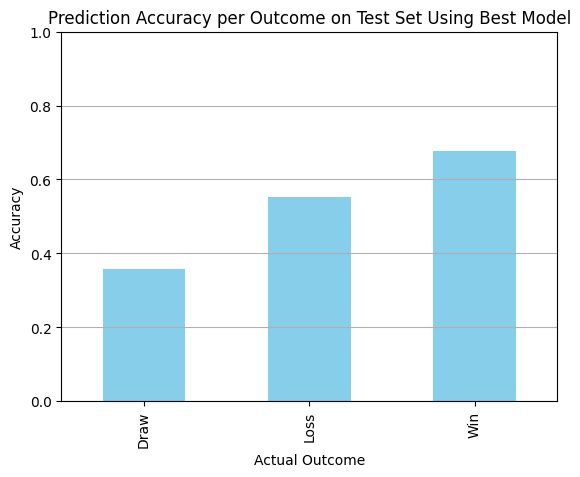

In [97]:
best_outcome_accuracy = best_test_results_df.groupby('Actual Outcome')['Correct'].mean()

best_outcome_accuracy.plot(kind='bar', color='skyblue')
plt.ylabel('Accuracy')
plt.title('Prediction Accuracy per Outcome on Test Set Using Best Model')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

Displaying Confidence in Best Model Predictions

In [98]:
low_confidence_threshold = 0.6

best_test_results_df['Low-Confidence Wrong'] = (
    (~best_test_results_df['Correct']) & (best_test_results_df['Confidence'] < low_confidence_threshold)
)

best_low_conf_wrong_preds = best_test_results_df[best_test_results_df['Low-Confidence Wrong']]

print(f"Low-Confidence Wrong Predictions: {len(low_conf_wrong_preds)} matches")
print(best_low_conf_wrong_preds[['Home Team', 'Away Team', 'Actual Outcome', 'Predicted Outcome', 'Confidence']])

Low-Confidence Wrong Predictions: 23 matches
   Home Team        Away Team Actual Outcome Predicted Outcome  Confidence
39    Fulham   Crystal Palace           Draw               Win    0.517141
57    Fulham  Manchester City           Loss               Win    0.494626


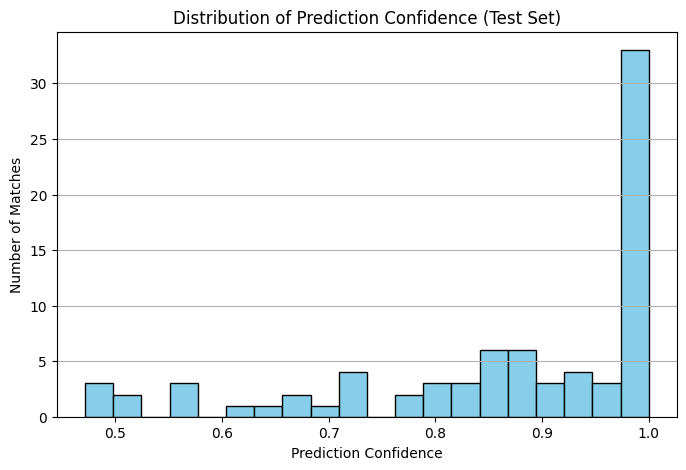

In [99]:
plt.figure(figsize=(8,5))
plt.hist(best_test_results_df['Confidence'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Prediction Confidence')
plt.ylabel('Number of Matches')
plt.title('Distribution of Prediction Confidence (Test Set)')
plt.grid(axis='y')
plt.show()

Plotting Permutation Feature Importance for the Best Model

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


2025-05-14 11:37:00.665355: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-14 11:37:00.681958: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-14 11:37:00.682636: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-14 11:37:00.780575: I tensorflow/core/platform/cpu_featu

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/stepp
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3/3 ━━━━━━━

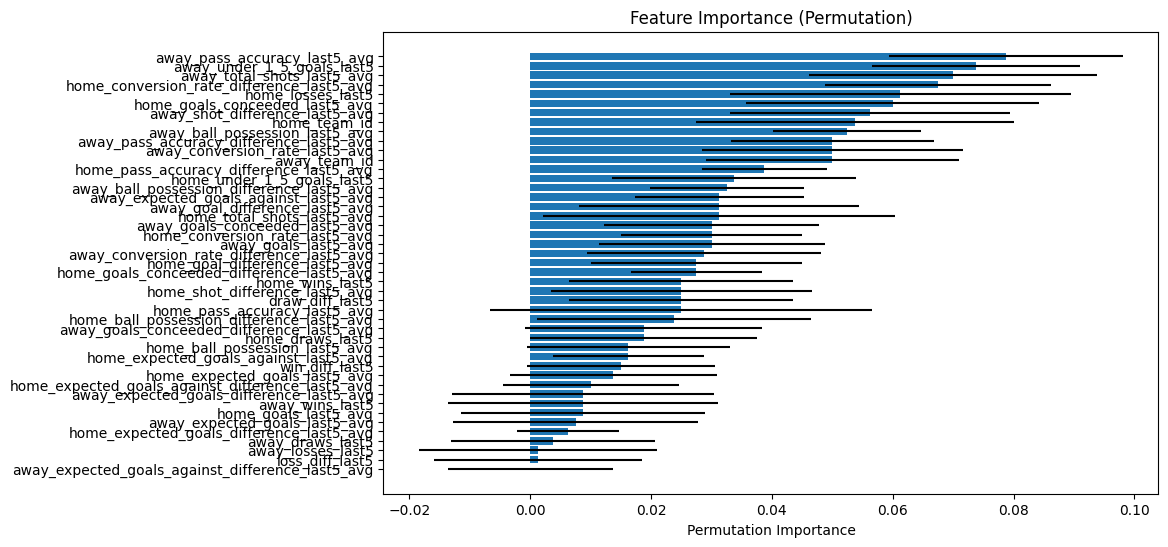

In [100]:
def keras_accuracy(y_true, y_pred):
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)
    return accuracy_score(y_true_classes, y_pred_classes)

result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1, scoring=make_scorer(keras_accuracy))

importance = result.importances_mean  
std = result.importances_std  

for i, imp in enumerate(importance):
    print(f"Feature {i}: Importance = {imp}, Standard Deviation = {std[i]}")

sorted_idx = importance.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(X_test.shape[1]), importance[sorted_idx], xerr=std[sorted_idx], align="center")
plt.yticks(range(X_test.shape[1]), X_test.columns[sorted_idx])  # Assuming X_test has columns
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Permutation)")
plt.show()